# Experiment Notebook: System Metrics

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Sanity Checks](#Analysis-1:-Sanity-Checks)
* [Analysis 2: Correlation Matrix](#Analysis-1:-Correlation-Matrix)

# Experiment Summary 

The purpose of this notebook is to demonstrate the system's standard metrics, KPIs and goals.

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 895 ms (started: 2022-07-06 13:54:47 -04:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 23.7 ms (started: 2022-07-06 13:54:48 -04:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 24.2 ms (started: 2022-07-06 13:54:48 -04:00)


In [4]:
# Inspect experiment template
display_code(default_experiment)

"""
The default experiment with default model Initial State, System Parameters, and Simulation Configuration.
The defaults are defined in their respective modules:
* Initial State in `model/state_variables.py`
* System Parameters in `model/system_parameters.py`
* Simulation Configuration in `experiments/simulation_configuration.py`
"""

from radcad import Simulation, Experiment, Backend

from model import model
from experiments.simulation_configuration import TIMESTEPS, MONTE_CARLO_RUNS
from model.initialization import setup_initial_state, setup_state_update_blocks


# Create Model Simulation
simulation = Simulation(
    model=model,
    timesteps=TIMESTEPS,
    runs=MONTE_CARLO_RUNS
)
# Create Experiment of single Simulation
experiment = Experiment([simulation])
# Configure Simulation & Experiment engine
simulation.engine = experiment.engine
experiment.engine.backend = Backend.SINGLE_PROCESS
experiment.engine.deepcopy = True
experiment.engine.drop_substeps = True

# Configure simulation hooks
before_subset = lambda context: [
    setup_initial_state(context),
    setup_state_update_blocks(context)
]
simulation.before_subset = before_subset
experiment.before_subset = before_subset

time: 107 ms (started: 2022-07-06 13:54:48 -04:00)


In [5]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_2 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_3 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 25.2 ms (started: 2022-07-06 13:54:48 -04:00)


In [6]:
# Experiment configuration
# simulation_1.model.initial_state.update({})
# simulation_1.model.params.update({})

time: 23.7 ms (started: 2022-07-06 13:54:48 -04:00)


# Analysis 1: PCV Sanity Checks

A simulation across 4 volatile asset price scenarios to validate PCV states and metrics.

In [7]:
# Analysis-specific setup
simulation_1.model.params.update({
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 22.9 ms (started: 2022-07-06 13:54:48 -04:00)


In [8]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-07-06 13:54:48,875 - root - INFO - Running experiment
2022-07-06 13:54:48,879 - root - INFO - Setting up initial state
2022-07-06 13:54:48,884 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-06 13:54:49,548 - root - INFO - Setting up initial state
2022-07-06 13:54:49,552 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-06 13:54:50,208 - root - INFO - Setting up initial state
2022-07-06 13:54:50,212 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-07-06 13:54:50,867 - root - INFO - Setting up initial state
2022-07-06 13:54:50,871 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-07-06 13:54:51,535 - root - INFO - Experiment complete in 2.6580960750579834 seconds
2022-07-06 13:54:51,535 - root - INFO - Post-processing results
2022-07-06 13:54:53,201 - root - INFO - Post-processing complete in 1.6669390201568604 seconds
time: 4.35 s (started: 2022-07-06 13:54:48 -04:00)


In [9]:
# Post-processing and visualizations

time: 22.4 ms (started: 2022-07-06 13:54:53 -04:00)


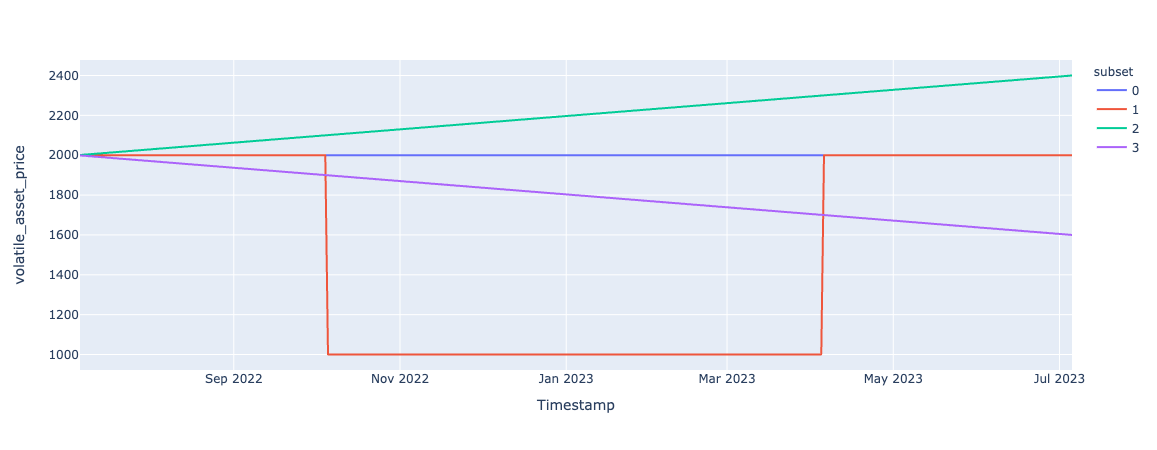

time: 1.12 s (started: 2022-07-06 13:54:53 -04:00)


In [10]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

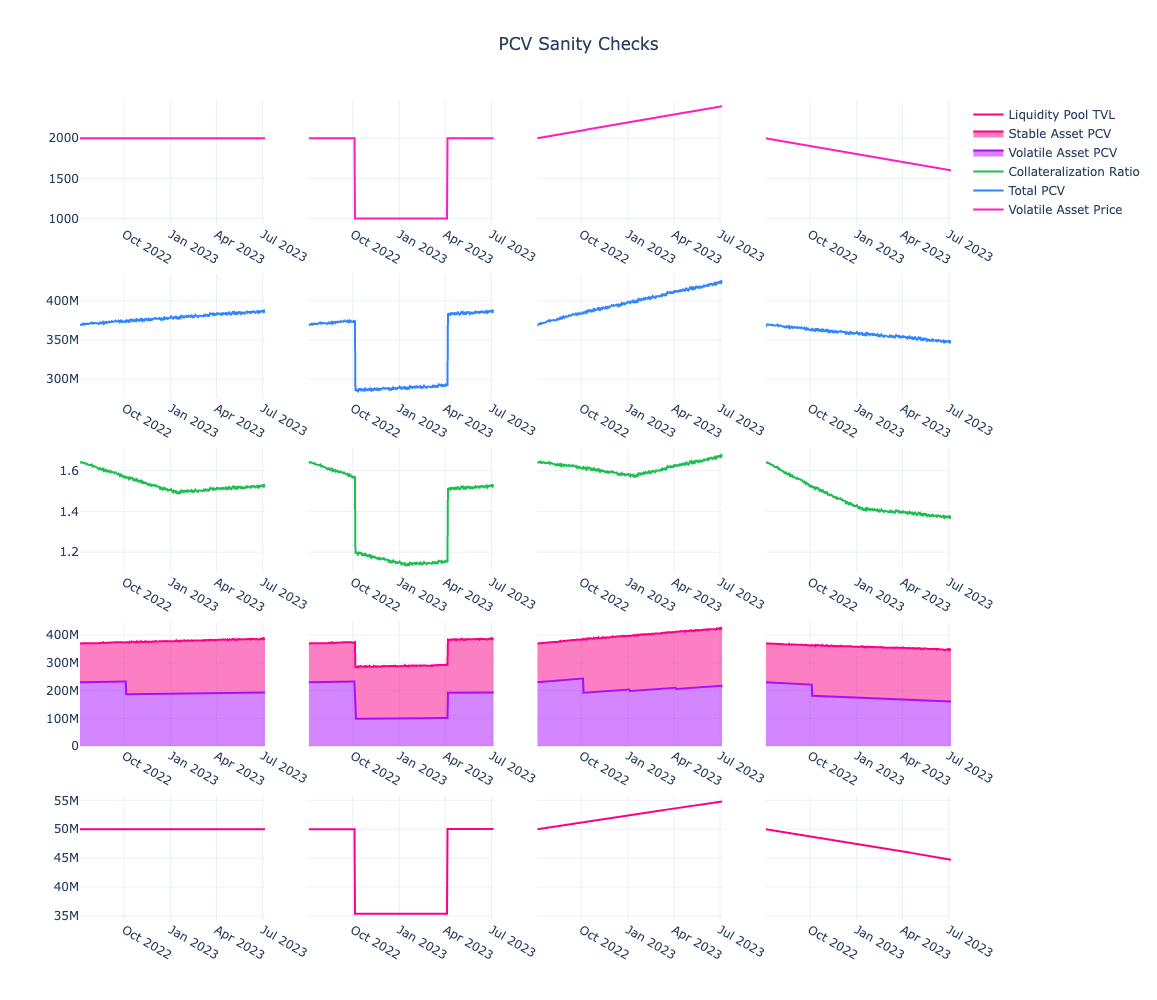

time: 822 ms (started: 2022-07-06 13:54:54 -04:00)


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


fig = make_subplots(rows=5, cols=len(df.subset.unique()), shared_yaxes=True)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[0]),
            showlegend=(True if subset == 0 else False),
        ),
        row=1, col=subset+1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_pcv,
            name="Total PCV",
            line=dict(color=cadlabs_colorway_sequence[1]),
            showlegend=(True if subset == 0 else False),
        ),
        row=2, col=subset+1
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[2]),
            showlegend=(True if subset == 0 else False),
        ),
        row=3, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[3]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
        ),
        row=5, col=subset+1
    )


fig.update_layout(height=1000, title_text="PCV Sanity Checks")
fig.show()

# Analysis 2: Correlation Matrix

In [98]:
# Analysis-specific setup
simulation_2.model.params.update({})

time: 32.9 ms (started: 2022-07-06 14:19:27 -04:00)


In [99]:
# Experiment execution
df, exceptions = run(simulation_2)

2022-07-06 14:19:27,713 - root - INFO - Running experiment
2022-07-06 14:19:27,715 - root - INFO - Setting up initial state
2022-07-06 14:19:27,719 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-06 14:19:28,294 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-06 14:19:28,502 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-06 14:19:28,506 - root - INFO - Setting up initial state
2022-07-06 14:19:28,510 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-06 14:19:29,280 - root - INFO - Experiment complete in 1.5654871463775635 seconds
2022-07-06 14:19:29,281 - root - INFO - Post-processing results
2022-07-06 14:19:30,158 - root - INFO - Post-processing complete in 0.8777949810028076 seconds
time: 2.48 s (started: 2022-07-06 14:19:27 -04:00)


In [100]:
# Post-processing and visualizations

time: 94 ms (started: 2022-07-06 14:19:30 -04:00)


2022-07-06 14:19:34,808 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x12c0818b0>
2022-07-06 14:19:34,809 - matplotlib.colorbar - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x12c0818b0> on colorbar
2022-07-06 14:19:34,809 - matplotlib.colorbar - DEBUG - Setting pcolormesh


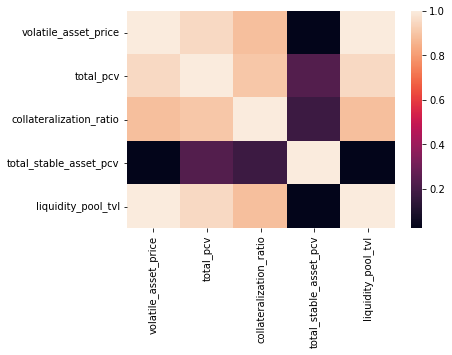

time: 333 ms (started: 2022-07-06 14:19:34 -04:00)


In [102]:
# import seaborn as sns

# corr = df[[
#     "volatile_asset_price",
#     "total_pcv",
#     "collateralization_ratio",
#     "total_stable_asset_pcv",
#     "liquidity_pool_tvl"
# ]].corr()

# _ = sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

# import plotly.plotly as py
# from plotly.graph_objs import *

# trace1 = {
#   "type": "heatmap", 
#   "x": ["fp_time", "uid", "revenue", "num_trans", "act_days", "lt", "delt_pmnt_log"], 
#   "y": ["fp_time", "uid", "revenue", "num_trans", "act_days", "lt", "delt_pmnt_log"], 
#   "z": [],
# }

# data = Data([trace1])
# layout = {"title": "Features Correlation Matrix"}
# fig = Figure(data=data, layout=layout)
# plot_url = py.plot(fig)

# PCV at Risk

In [76]:
from operator import lt, gt

time: 33 ms (started: 2022-07-06 14:13:26 -04:00)


In [86]:
simulation_3.runs = 20

parameter_overrides = {
    "target_rebalancing_condition": [gt, lt], # Simulate decrease and increase of stable PCV
    "target_stable_pcv_ratio": [0.2, 0.5], # Simulate decrease and increase of stable PCV
    "rebalancing_period": [int(365 / 4)],
}

simulation_3.model.params.update(parameter_overrides)

time: 34.1 ms (started: 2022-07-06 14:16:59 -04:00)


In [87]:
# Experiment execution
df, exceptions = run(simulation_3)

2022-07-06 14:17:00,072 - root - INFO - Running experiment
2022-07-06 14:17:00,073 - root - INFO - Setting up initial state
2022-07-06 14:17:00,078 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-06 14:17:00,661 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-06 14:17:00,872 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-06 14:17:00,876 - root - INFO - Setting up initial state
2022-07-06 14:17:00,880 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-06 14:17:01,651 - root - INFO - Setting up initial state
2022-07-06 14:17:01,655 - root - INFO - Starting simulation 0 / run 1 / subset 0
2022-07-06 14:17:02,416 - root - INFO - Setting up initial state
2022-07-06 14:17:02,420 - root - INFO - Starting simulation 0 / run 1 / subset 1
2022-07-06 14:17:03,201 - root - INFO - Setting up initial state
2022-07-06 14:17:03,205 - root - INFO - Starting simulation 0 / run 2 / subset 0
2022-07-06 14:17:03,384 - root - WARNING - Cashing 

In [88]:
df

timestamp  total_fei_supply  \
timestamp                                                                 
2022-07-06 13:54:48.536627 2022-07-06 13:54:48.536627      4.500000e+08   
2022-07-07 13:54:48.536627 2022-07-07 13:54:48.536627      4.501627e+08   
2022-07-08 13:54:48.536627 2022-07-08 13:54:48.536627      4.503113e+08   
2022-07-09 13:54:48.536627 2022-07-09 13:54:48.536627      4.503546e+08   
2022-07-10 13:54:48.536627 2022-07-10 13:54:48.536627      4.503629e+08   
...                                               ...               ...   
2023-07-01 13:54:48.536627 2023-07-01 13:54:48.536627      4.500532e+08   
2023-07-02 13:54:48.536627 2023-07-02 13:54:48.536627      4.502685e+08   
2023-07-03 13:54:48.536627 2023-07-03 13:54:48.536627      4.501513e+08   
2023-07-04 13:54:48.536627 2023-07-04 13:54:48.536627      4.501098e+08   
2023-07-05 13:54:48.536627 2023-07-05 13:54:48.536627      4.501334e+08   

                            total_protocol_owned_fei  \
timestamp                                              
2022-07-06 13:54:48.536627              2.250000e+08   
2022-07-07 13:54:48.536627              2.250127e+08   
2022-07-08 13:54:48.536627              2.250113e+08   
2022-07-09 13:54:48.536627              2.249046e+08   
2022-07-10 13:54:48.536627              2.247629e+08   
...                                              ...   
2023-07-01 13:54:48.536627              1.965532e+08   
2023-07-02 13:54:48.536627              1.967685e+08   
2023-07-03 13:54:48.536627              1.966513e+08   
2023-07-04 13:54:48.536627              1.966098e+08   
2023-07-05 13:54:48.536627              1.966334e+08   

                            total_user_circulating_fei  \
timestamp                                                
2022-07-06 13:54:48.536627                 225000000.0   
2022-07-07 13:54:48.536627                 225150000.0   
2022-07-08 13:54:48.536627                 225300000.0   
2022-07-09 13:54:48.536627                 225450000.0   
2022-07-10 13:54:48.536627                 225600000.0   
...                                                ...   
2023-07-01 13:54:48.536627                 253500000.0   
2023-07-02 13:54:48.536627                 253500000.0   
2023-07-03 13:54:48.536627                 253500000.0   
2023-07-04 13:54:48.536627                 253500000.0   
2023-07-05 13:54:48.536627                 253500000.0   

                            idle_user_circulating_fei  fei_minted_redeemed  \
timestamp                                                                    
2022-07-06 13:54:48.536627                  225000000        162681.185922   
2022-07-07 13:54:48.536627                  225000000        148572.468261   
2022-07-08 13:54:48.536627                  225000000         43306.127840   
2022-07-09 13:54:48.536627                  225000000          8297.996994   
2022-07-10 13:54:48.536627                  225000000        -33549.660037   
...                                               ...                  ...   
2023-07-01 13:54:48.536627                  225000000        215256.052476   
2023-07-02 13:54:48.536627                  225000000       -117104.718869   
2023-07-03 13:54:48.536627                  225000000        -41522.877377   
2023-07-04 13:54:48.536627                  225000000         23615.060984   
2023-07-05 13:54:48.536627                  225000000       -192534.314418   

                            cumulative_psm_redemptions  fei_price  \
timestamp                                                           
2022-07-06 13:54:48.536627                         0.0        1.0   
2022-07-07 13:54:48.536627                         0.0        1.0   
2022-07-08 13:54:48.536627                         0.0        1.0   
2022-07-09 13:54:48.536627                         0.0        1.0   
2022-07-10 13:54:48.536627                         0.0        1.0   
...                                                ...        ...   
2023-07-01 13:54:

time: 76.7 ms (started: 2022-07-06 14:17:49 -04:00)


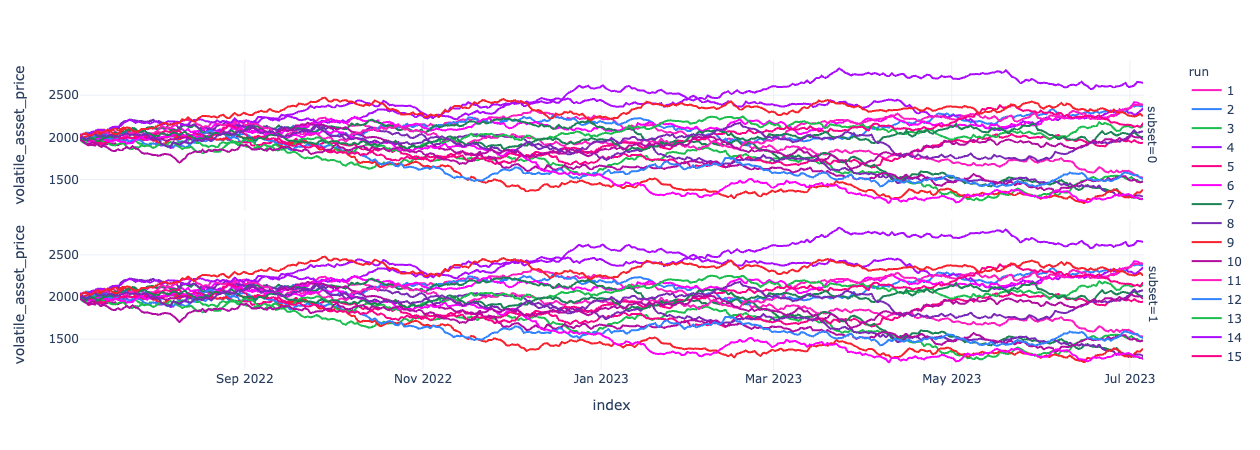

time: 936 ms (started: 2022-07-06 14:17:49 -04:00)


In [89]:
df.plot(y="volatile_asset_price", color="run", facet_row="subset")

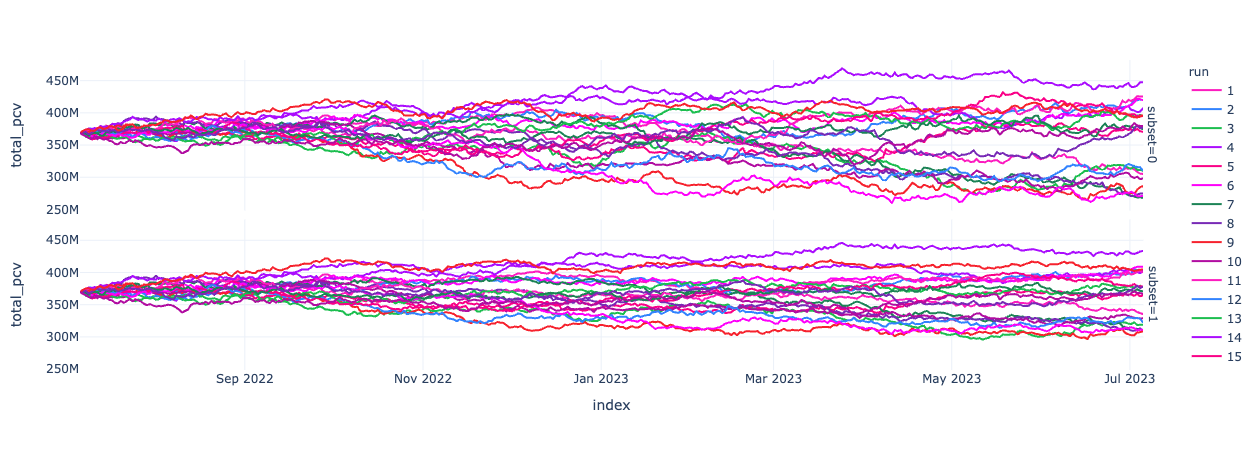

time: 1.01 s (started: 2022-07-06 14:17:50 -04:00)


In [90]:
df.plot(y="total_pcv", color="run", facet_row="subset")

In [91]:
pcv_ret = df.query('run==8')['total_pcv'].pct_change()

time: 44.4 ms (started: 2022-07-06 14:17:51 -04:00)


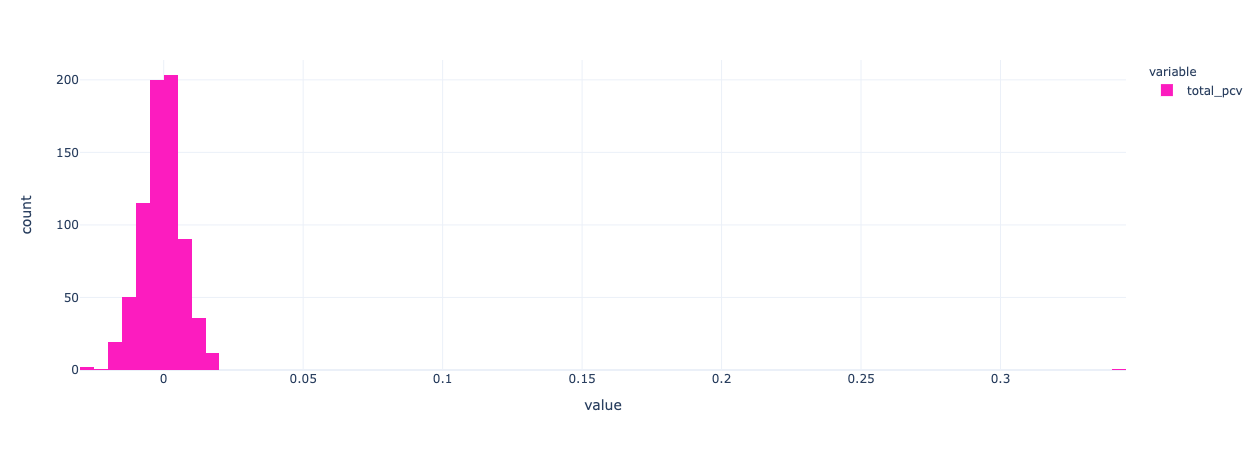

time: 95 ms (started: 2022-07-06 14:17:51 -04:00)


In [92]:
pcv_ret.hist(bins=30)

In [93]:
q_95 = pcv_ret.quantile(1-0.95)

time: 34.2 ms (started: 2022-07-06 14:17:51 -04:00)


In [94]:
q_95

-0.01310420543318497

time: 34.8 ms (started: 2022-07-06 14:17:51 -04:00)


In [95]:
pcv_final_val = df.query('run==8')['total_pcv'].iloc[-1]

time: 39.6 ms (started: 2022-07-06 14:17:51 -04:00)


In [96]:
pcv_final_val

310566617.60398793

time: 35 ms (started: 2022-07-06 14:17:51 -04:00)


In [97]:
abs(pcv_final_val * q_95)

4069728.7577720573

time: 35.6 ms (started: 2022-07-06 14:17:52 -04:00)
